# Gauge Observables

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = 5 * ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = 5 * ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'P', 'D']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

tf.enable_eager_execution()
tfe = tf.contrib.eager

In [2]:
import utils.file_io as io
from lattice.lattice import GaugeLattice, u1_plaq_exact
#from l2hmc_eager import gauge_dynamics_eager as gde
from gauge_model import GaugeModel
from utils.file_io import save_params_to_pkl_file
from utils.observables import Observables

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib notebook

## Helper functions

In [3]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)
        
def plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax
        

## Observables analysis

### Helper functions

In [13]:
def load_stats_and_observables(d):
    """Load actions, plaqs. and top. charges from `.pkl` files in dir `d`."""
    actions_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('actions_steps') and i.endswith('.pkl')
    ]
    plaqs_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('plaqs_steps') and i.endswith('.pkl')
    ]
    charges_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('charges_steps') and i.endswith('.pkl')
    ]
    tun_events_file = [
        os.path.join(d, i) for i in os.listdir(d)
        if i.startswith('charge_diff') and i.endswith('.pkl')
    ]
    with open(actions_file[0], 'rb') as f:
        actions_dict = pickle.load(f)
    with open(plaqs_file[0], 'rb') as f:
        plaqs_dict = pickle.load(f)
    with open(charges_file[0], 'rb') as f:
        charges_dict = pickle.load(f)
    with open(tun_events_file[0], 'rb') as f:
        tun_events = pickle.load(f)
        
    return actions_dict, plaqs_dict, charges_dict, tun_events

In [ ]:
def plot_observables(steps_arr, observables, train=False):
    actions_arr, plaqs_arr, charges_arr = observables
    ######################
    # Total actions plots
    ######################
    if train:
        key = 'train'
    else:
        key = 'eval'
    title_str = (r"$\beta = $"
                 f"{beta}, {len(steps_arr)} {key} steps")
    kwargs = {
        'out_file': None,
        'markers': False,
        'lines': True,
        'alpha': 0.6,
        'title': title_str,
        'legend': False,
        'ret': False,
    }
    plot_multiple_lines(steps_arr, actions_arr.T,  x_label='Step', 
                        y_label='Total action', **kwargs)

    ###########################
    # Average plaquettes plots
    ###########################
    kwargs['ret'] = True
    _, ax = plot_multiple_lines(steps_arr, plaqs_arr.T, x_label='Step',
                                y_label='Avg. plaquette', **kwargs)

    _ = ax.axhline(y=u1_plaq_exact(beta),
                   color='#CC0033', ls='-', lw=2.5, label='exact')

    _ = ax.plot(steps_arr, plaqs_arr.T.mean(axis=0),
                color='k', label='average', alpha=0.75)


    ############################
    # Topological charge plots
    ############################
    kwargs['markers'] = True
    kwargs['lines'] = False
    kwargs['alpha'] = 1.
    kwargs['ret'] = False
    plot_multiple_lines(steps_arr, charges_arr.T, x_label='Step',
                        y_label='Topological charge', **kwargs)

In [82]:
def plot_charge_probs(charges_arr, beta, params, out_dir=None, training=False):
    if training:
        key = 'train'
    else:
        key = 'eval'
        
    num_samples = params['num_samples']
    charges = np.array(charges_arr, dtype=int)
    _run_steps = charges.shape[0]

    title_str = (r"$\beta = $"
                 f"{beta}, {_run_steps} {key} steps")
    # if we have more than 5 samples per batch, only plot first 5
    for idx in range(5):
        counts = Counter(charges[:, idx])
        total_counts = np.sum(list(counts.values()))
        _, ax = plt.subplots()
        ax.plot(list(counts.keys()),
                np.array(list(counts.values()) / total_counts),
                marker=MARKERS[idx],
                color=COLORS[idx],
                ls='',
                label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Topological charge', fontsize=14)
        _ = ax.set_ylabel('Probability', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        if out_dir is not None:
            out_file = os.path.join(out_dir,
                                    f'top_charge_prob_vs_val_{idx}.png')
            io.log(f'Saving figure to: {out_file}.')
            _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        #plt.close('all')

    all_counts = Counter(list(charges.flatten()))
    total_counts = np.sum(list(counts.values()))
    _, ax = plt.subplots()
    ax.plot(list(all_counts.keys()),
            np.array(list(all_counts.values()) / (total_counts * num_samples)),
            marker='o',
            color='C0',
            ls='',
            alpha=0.6,
            label=f"total across {num_samples} samples");
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Probability', fontsize=14)
    _ = ax.set_title(title_str, fontsize=16)
    if out_dir is not None:
        out_file = os.path.join(out_dir,
                                f'TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png')
        io.log(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    #plt.close('all')

### Define log_dir and traverse directory structure

In [83]:
#'../../conv3D_logs/lattice_88/lr5e-4/fourier_approx/run_9/'
#'../../conv3D_logs/lattice_1616/fourier_approx/run_1/'
log_dir = os.path.join('..', '..', 'conv3D_logs', 'HMC',
                       'run_L8_7')
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
eval_dir = os.path.join(log_dir, 'eval_info')
obs_dir = os.path.join(eval_dir, 'observables')
training_obs_dir = os.path.join(obs_dir, 'training')

In [84]:
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)
for key, val in params.items():
    print(f'{key}: {val}')

space_size: 8
time_size: 8
link_type: U1
dim: 2
num_samples: 56
rand: False
num_steps: 5
eps: 0.3
loss_scale: 1.0
lr_init: 0.001
lr_decay_steps: 500
lr_decay_rate: 0.96
annealing: False
beta_init: 4.0
beta_final: 4.0
train_steps: 1000
save_steps: 50
print_steps: 1
logging_steps: 50
training_samples_steps: 1000
training_samples_length: 500
network_arch: conv3D
summaries: False
hmc: True
eps_trainable: False
metric: cos_diff
std_weight: 1.0
aux_weight: 1.0
charge_weight: 1.0
clip_grads: False
clip_value: 1.0
log_dir: conv3D_logs/lattice_88/HMC
restore: False
profiler: False
gpu: False
theta: False
horovod: False
num_intra_threads: 0
beta: 4.0
data_format: channels_last
_plot: True


In [85]:
obs_dirs = [
    os.path.join(obs_dir, i) for i in os.listdir(obs_dir) if 'steps' in i
]
try:
    training_obs_dirs = [
        os.path.join(training_obs_dir, i) for i in os.listdir(training_obs_dir)
    ]
except FileNotFoundError:
    training_obs_dirs = None
    pass
obs_dirs
training_obs_dirs

['../../conv3D_logs/HMC/run_L8_7/eval_info/observables/steps_20000_beta_3.0',
 '../../conv3D_logs/HMC/run_L8_7/eval_info/observables/steps_20000_beta_4.0',
 '../../conv3D_logs/HMC/run_L8_7/eval_info/observables/steps_50000_beta_3.0',
 '../../conv3D_logs/HMC/run_L8_7/eval_info/observables/steps_50000_beta_4.0']

In [86]:
run_steps = [int(i.split('/')[-1].split('_')[1]) for i in obs_dirs]
betas = [float(i.split('/')[-1].split('_')[-1]) for i in obs_dirs]

try:
    training_steps = [
        int(i.split('/')[-1].split('_')[0]) for i in training_obs_dirs
    ]
    training_run_steps = [
        int(i.split('/')[-1].split('_')[3]) for i in training_obs_dirs
    ]
    training_betas = [
        float(i.split('/')[-1].split('_')[-1]) for i in training_obs_dirs
    ]
except TypeError:
    training_steps = []
    training_run_steps = []
    training_betas = []

In [87]:
figs_dir = os.path.join(log_dir, 'figures')
_names = [f'{s}_steps_beta_{b}' for s, b in zip(run_steps, betas)]
figs_dirs = [os.path.join(figs_dir, n) for n in _names]
_ = [io.check_else_make_dir(d) for d in figs_dirs]
figs_dirs

['../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0',
 '../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0',
 '../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0',
 '../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0']

<IPython.core.display.Javascript object>


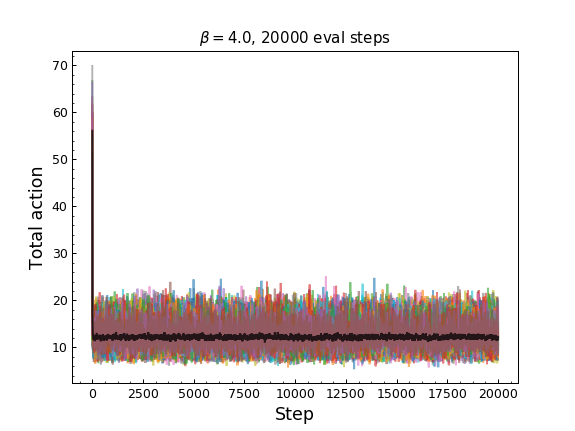

<IPython.core.display.Javascript object>


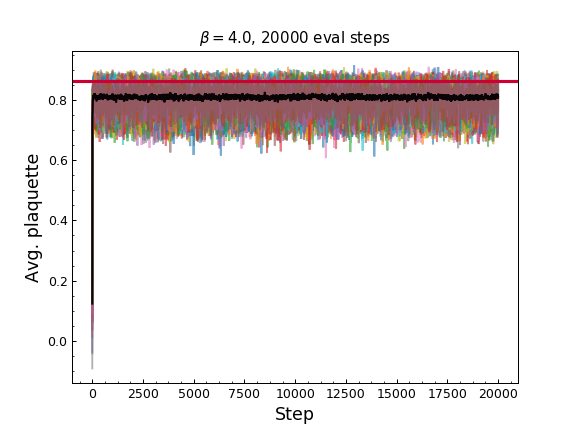

<IPython.core.display.Javascript object>


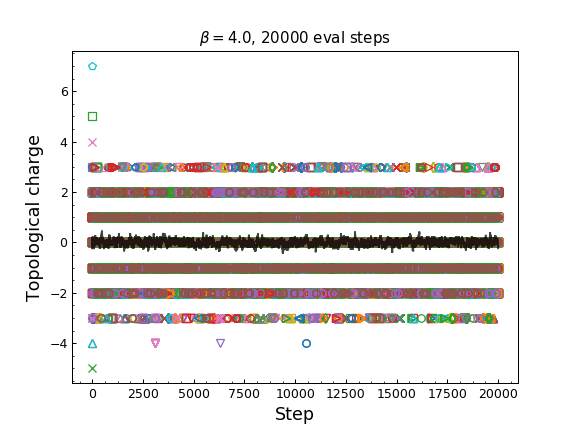

<IPython.core.display.Javascript object>


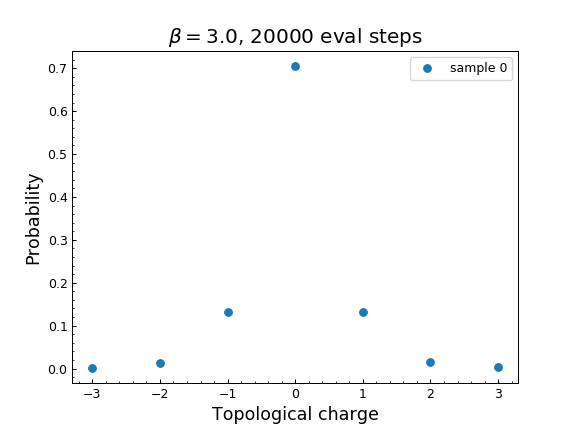

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_0.png.


<IPython.core.display.Javascript object>


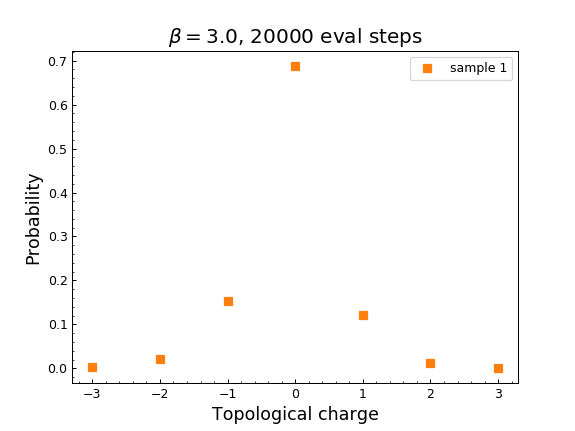

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_1.png.


<IPython.core.display.Javascript object>


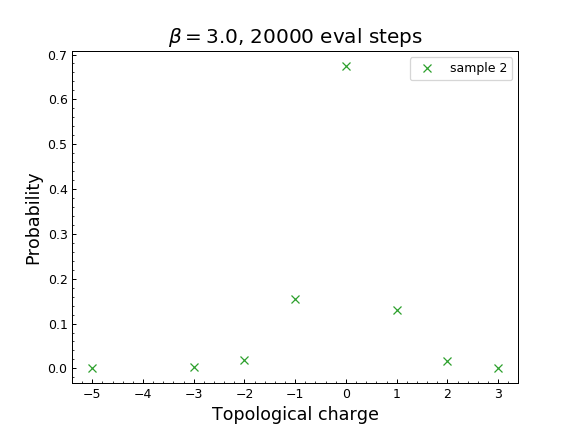

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_2.png.


<IPython.core.display.Javascript object>


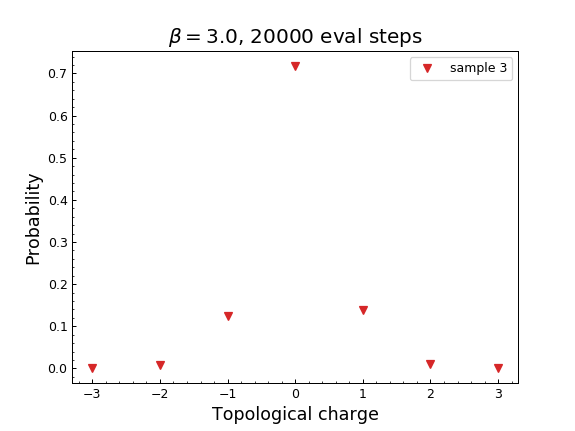

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_3.png.


<IPython.core.display.Javascript object>


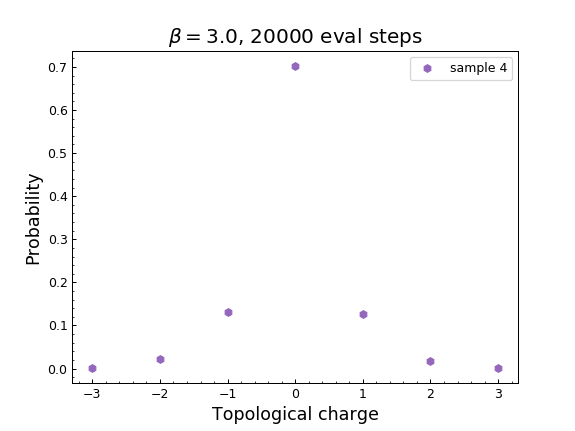

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_4.png.


<IPython.core.display.Javascript object>


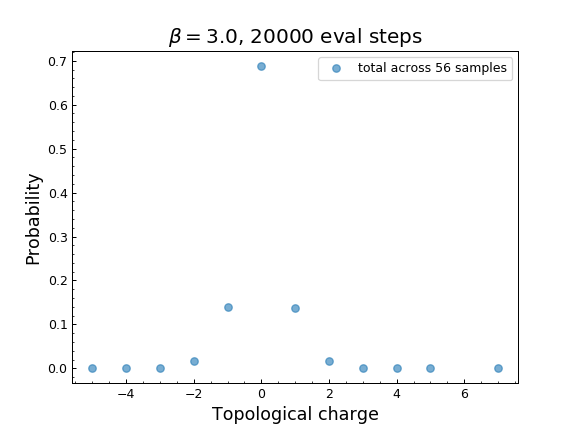

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_3.0/top_charge_probs/TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png.


<IPython.core.display.Javascript object>


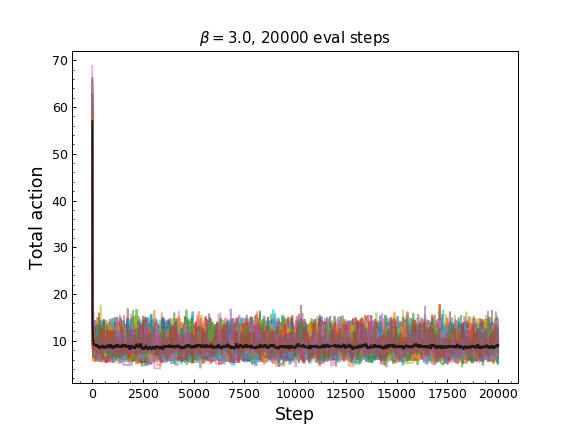

<IPython.core.display.Javascript object>


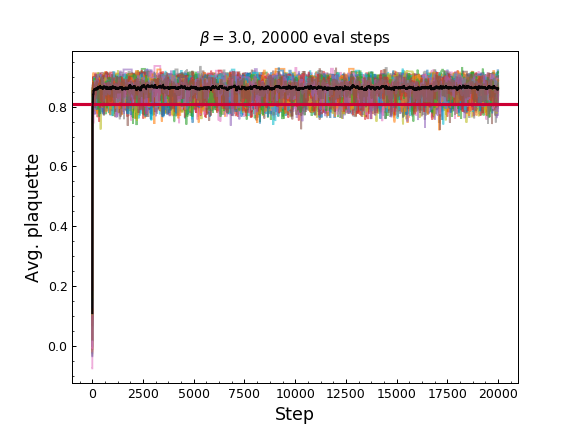

<IPython.core.display.Javascript object>


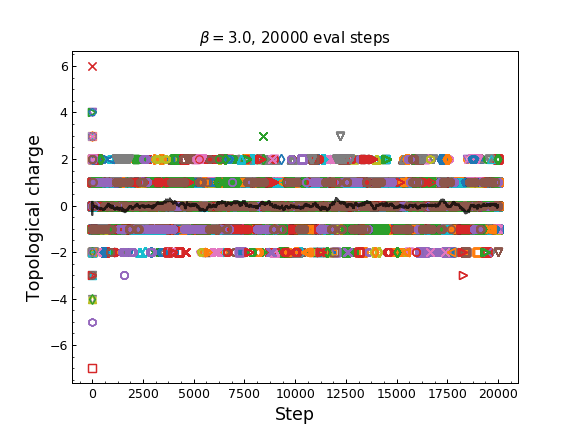

<IPython.core.display.Javascript object>


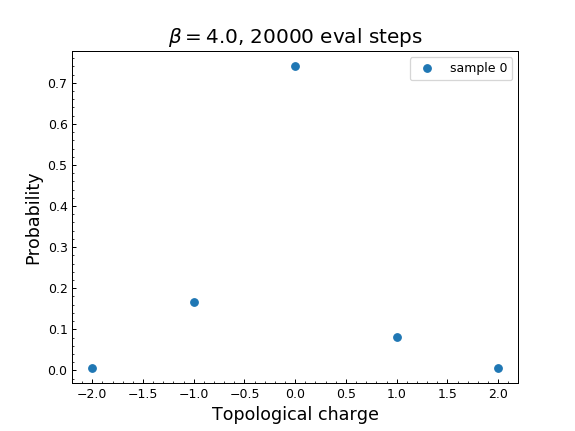

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_0.png.


<IPython.core.display.Javascript object>


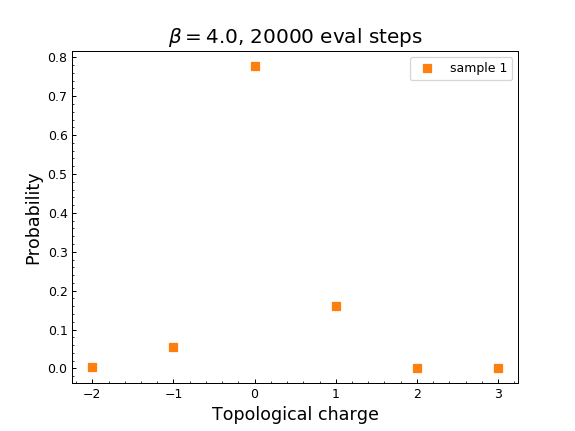

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_1.png.


<IPython.core.display.Javascript object>


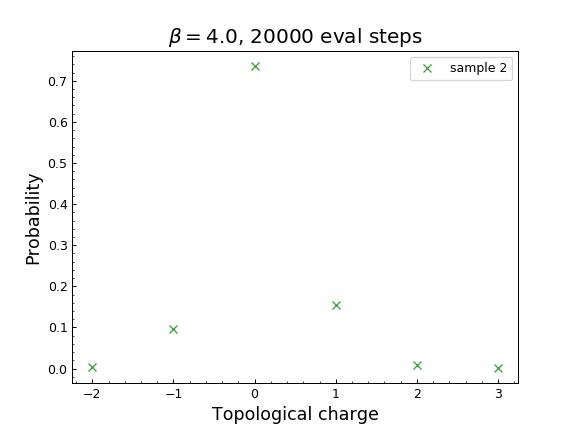

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_2.png.


<IPython.core.display.Javascript object>


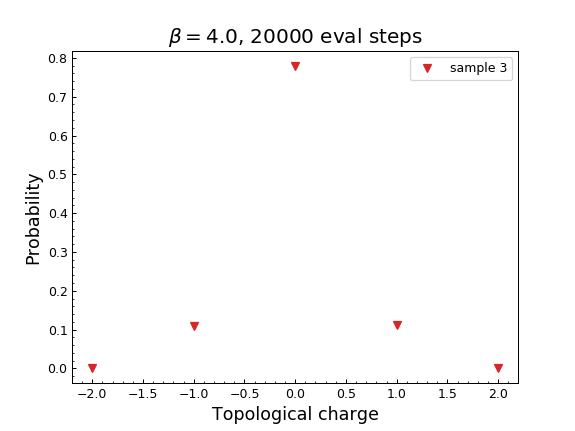

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_3.png.


<IPython.core.display.Javascript object>


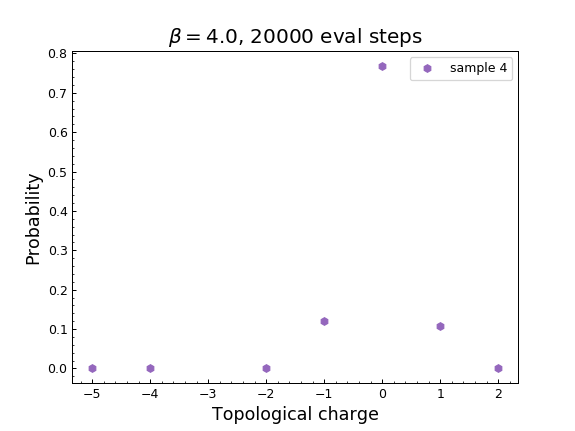

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_4.png.


<IPython.core.display.Javascript object>


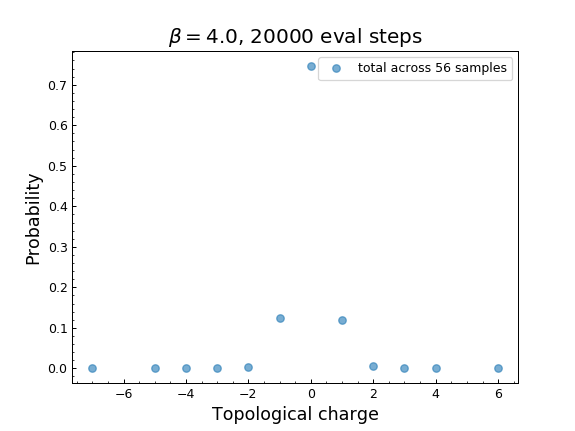

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/20000_steps_beta_4.0/top_charge_probs/TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png.


<IPython.core.display.Javascript object>


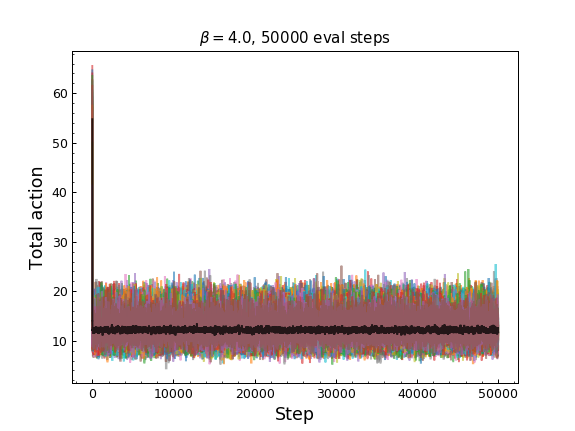

<IPython.core.display.Javascript object>


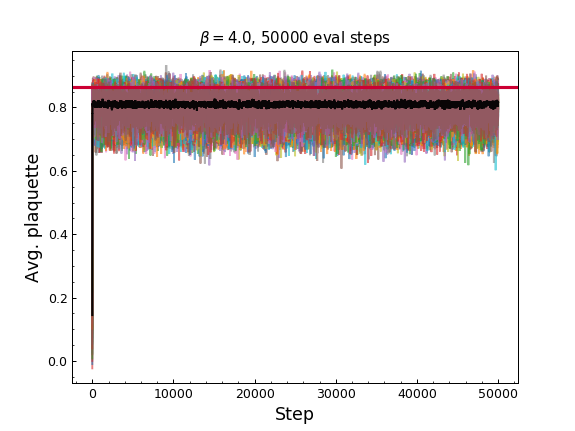

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


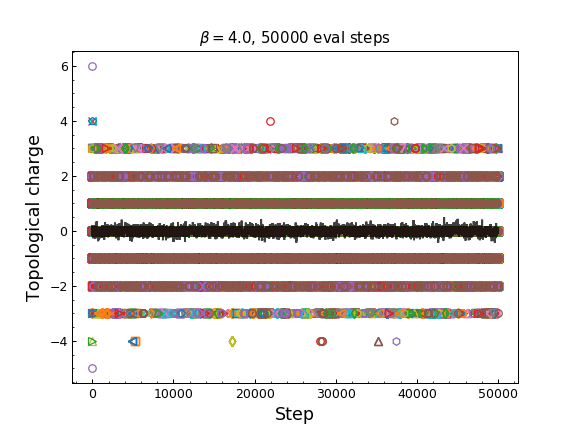

<IPython.core.display.Javascript object>


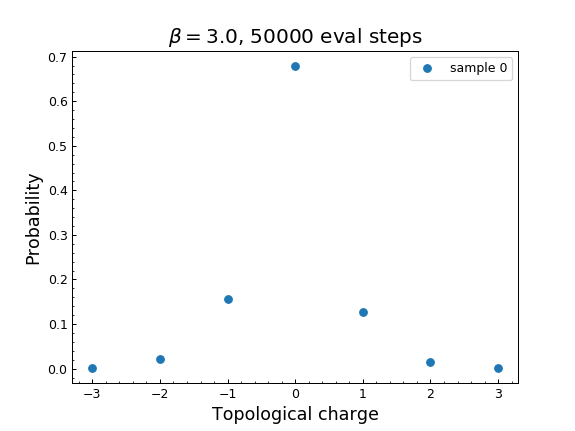

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_0.png.


<IPython.core.display.Javascript object>


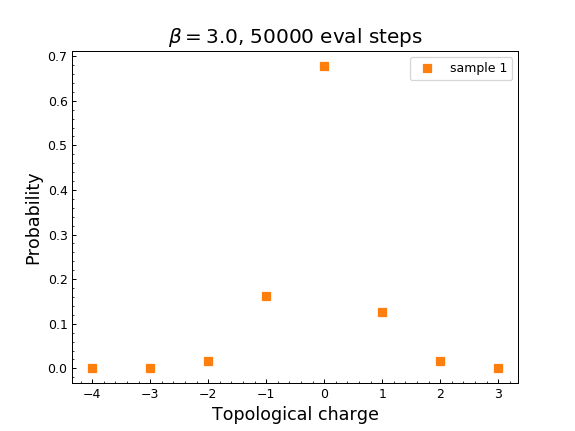

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_1.png.


<IPython.core.display.Javascript object>


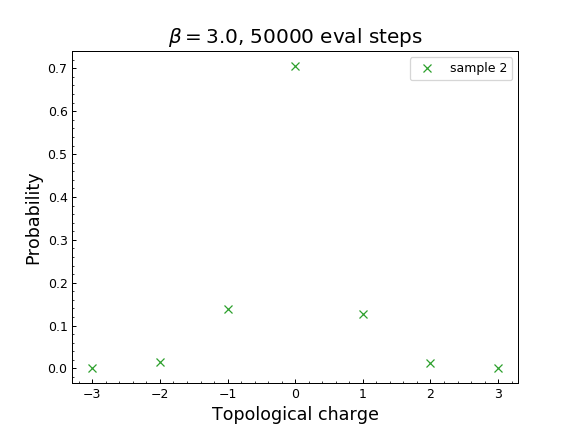

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_2.png.


<IPython.core.display.Javascript object>


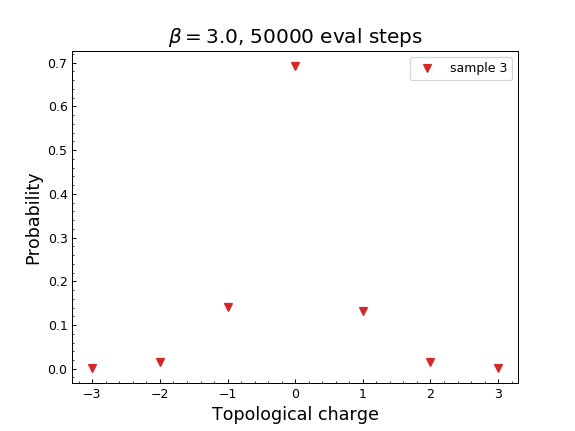

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_3.png.


<IPython.core.display.Javascript object>


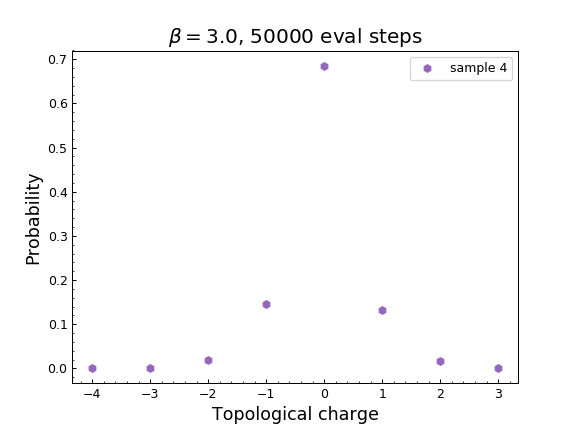

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/top_charge_prob_vs_val_4.png.


<IPython.core.display.Javascript object>


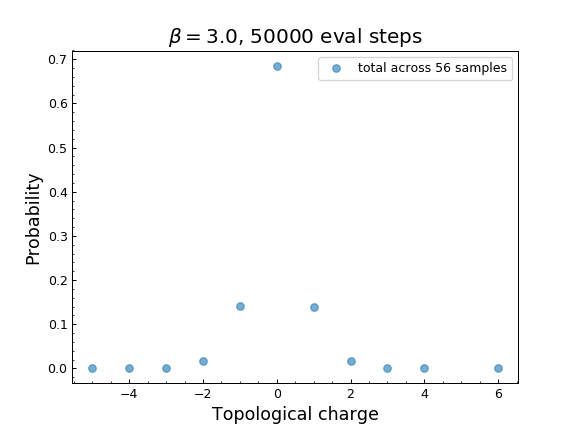

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_3.0/top_charge_probs/TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png.


<IPython.core.display.Javascript object>


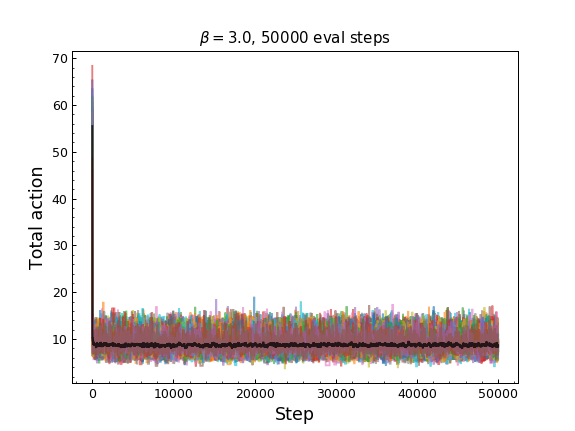

<IPython.core.display.Javascript object>


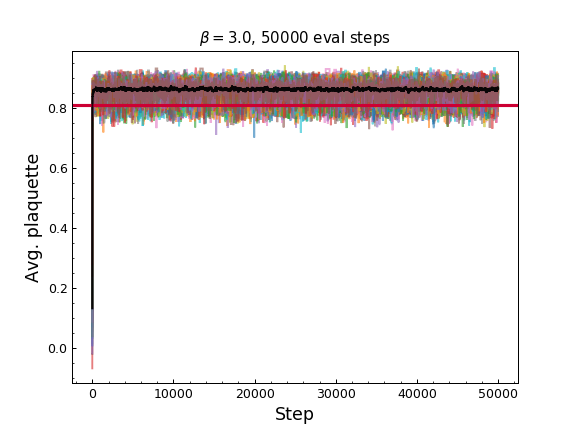

<IPython.core.display.Javascript object>


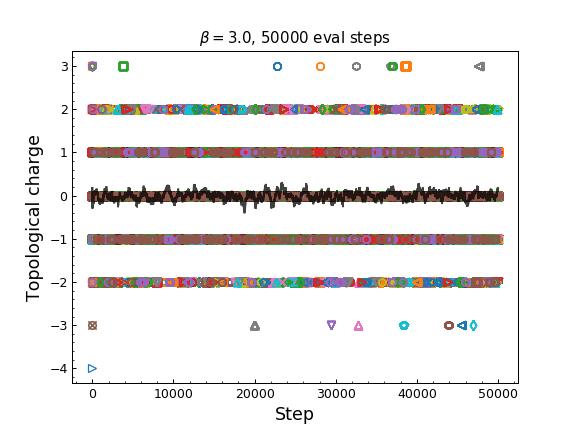

<IPython.core.display.Javascript object>


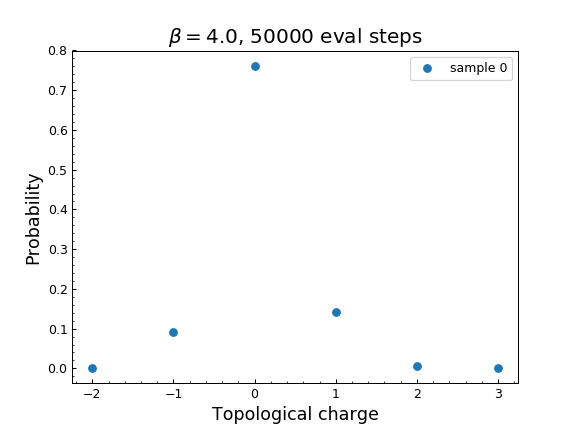

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_0.png.


<IPython.core.display.Javascript object>


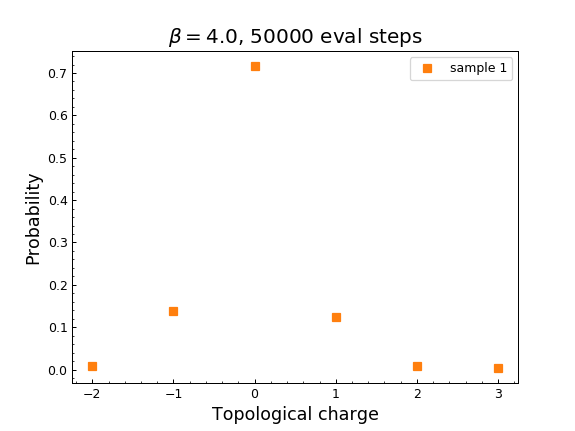

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_1.png.


<IPython.core.display.Javascript object>


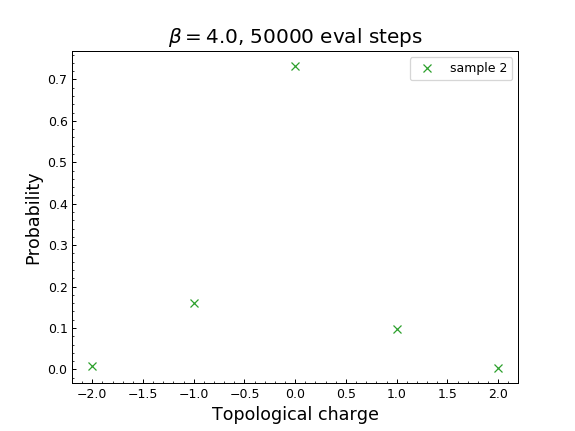

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_2.png.


<IPython.core.display.Javascript object>


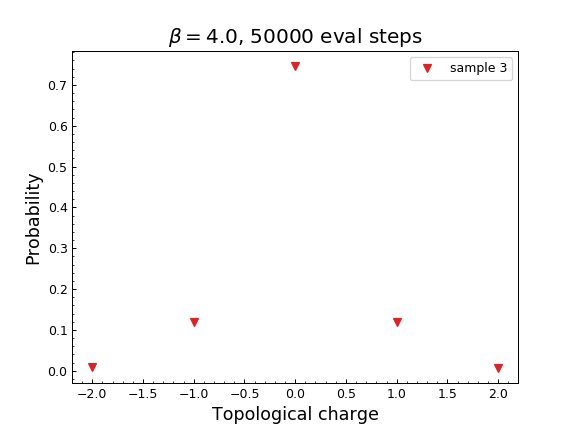

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_3.png.


<IPython.core.display.Javascript object>


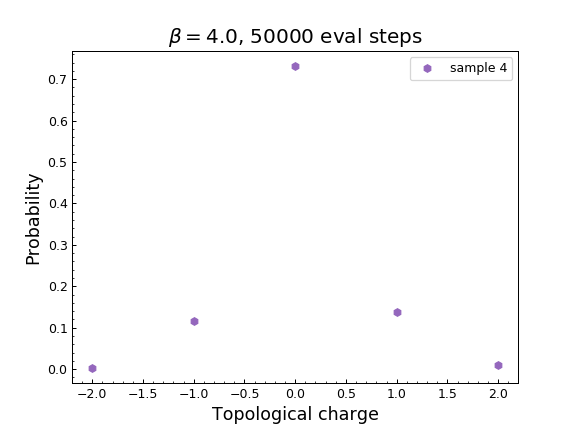

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/top_charge_prob_vs_val_4.png.


<IPython.core.display.Javascript object>


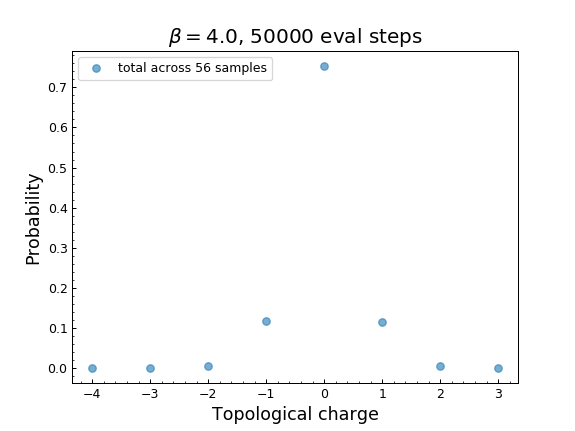

Saving figure to: ../../conv3D_logs/HMC/run_L8_7/figures/50000_steps_beta_4.0/top_charge_probs/TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png.


In [88]:
for idx, d in enumerate(obs_dirs):
    output = load_stats_and_observables(d)
    actions_dict, plaqs_dict, charges_dict, tun_events = output
    
    actions_arr = np.array(list(actions_dict.values()))
    plaqs_arr = np.array(list(plaqs_dict.values()))
    charges_arr = np.array(list(charges_dict.values()))

    keys_arr = np.array(list(actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    #beta = keys_arr[0, 1]
    #run_steps = charges.shape[0]
    observables = (actions_arr, plaqs_arr, charges_arr)
    plot_observables(steps_arr, observables, train=False)
    
    beta = betas[idx]
    out_dir = os.path.join(figs_dirs[idx], 'top_charge_probs')
    #num_samples = params['num_samples']
    plot_charge_probs(charges_arr, beta, params, out_dir, training=False)

In [68]:
output =  load_stats_and_observables(obs_dirs[1])
actions_dict, plaqs_dict, charges_dict, tun_events = output

In [69]:
actions_arr = np.array(list(actions_dict.values()))
plaqs_arr = np.array(list(plaqs_dict.values()))
charges_arr = np.array(list(charges_dict.values()))

keys_arr = np.array(list(actions_dict.keys()))
steps_arr = keys_arr[:, 0]
beta = keys_arr[0, 1]
_run_steps = charges.shape[0]

In [70]:
charges_arr = np.array(charges_arr, dtype=int)

In [71]:
from utils.plot_helper import plot_multiple_lines

<IPython.core.display.Javascript object>


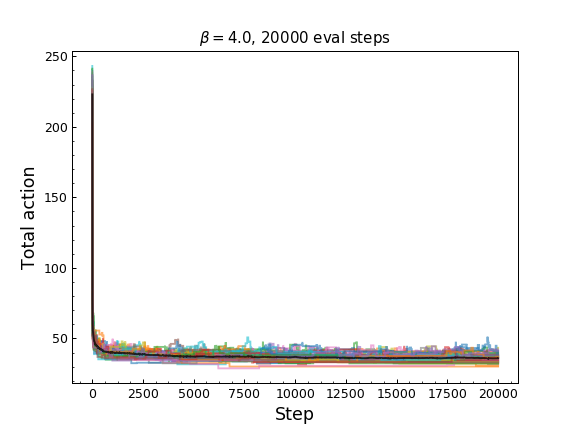

<IPython.core.display.Javascript object>


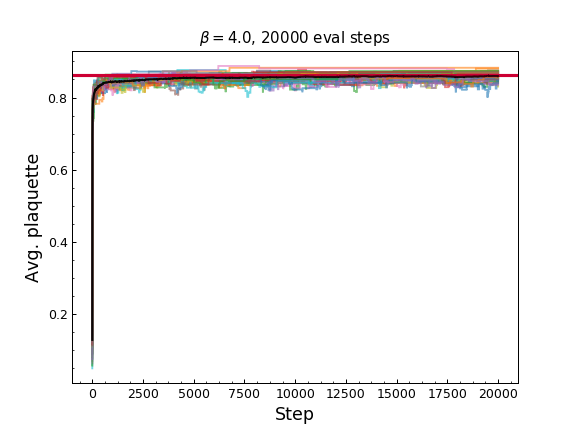

<IPython.core.display.Javascript object>


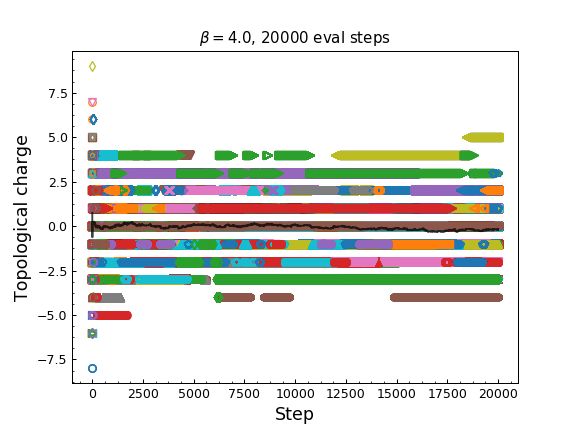

In [77]:
observables = (actions_arr, plaqs_arr, charges_arr)
plot_observables(steps_arr, observables, train=False)

In [66]:
beta = betas[1]
out_dir = os.path.join(figs_dirs[1], 'top_charge_probs')
num_samples = params['num_samples']

plot_charge_probs(charges_arr, beta, params, out_dir, training=False)

In [ ]:
x = np.arange(-4, 4, 1e-4)
y_exact = project_angle(x)
y_slow = linear_fft(x)
y_approx_arr = []
num_terms = [10, 20, 50, 100, 250, 500, 1000]
times = []
for n in num_terms:
    t0 = time.time()
    y_approx_arr.append(linear_fs(x, n))
    dt = time.time() - t0
    print(f'Time to complete ({n} terms): {dt:.4g}')
    times.append(time.time() - t0)

In [ ]:
errs = []
for idx, y in enumerate(y_approx_arr):
    err = sum((y - y_exact)/len(y_exact.numpy()))
    print(f"Error ({num_terms[idx]} terms): {err:.4g}")
    errs.append(err)

In [ ]:
%matplotlib notebook

In [ ]:
top_charges = int(
    0.1 + (tf.reduce_sum(ps_proj, axis=(1, 2),
                         name='top_charges') / 2 * np.pi)
)


In [ ]:
yy1 = np.array((y_exact / 2 * np.pi), dtype=int)
yy = np.array(y_approx_arr[1] / 2 * np.pi, dtype=int)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(yy)), yy1, label='exact')
ax.plot(np.arange(len(yy)), yy, label='fft')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for idx, y in enumerate(y_approx_arr):
    ax.plot(x, y, label = f'{num_terms[idx]} terms', alpha=0.7, ls='-');
ax.plot(x, y_exact, label='Exact', color='k');
ax.legend(loc='best', fontsize=10);
ax.set_xlabel('x');
ax.set_ylabel('y');
#ax.set_xlim((-np.pi-0.05, -np.pi + 0.05))
out_file = os.path.join(os.getcwd(), 'fourier_series_approx_zoom.png');
print(f'Saving figure to: {out_file}.');
plt.savefig(out_file, dpi=400, bbox_inches='tight');
plt.show();

In [ ]:
fn_val[:10]

In [ ]:
y_exact[:10]

In [ ]:
fig, ax = plt.subplots()
for idx, y in enumerate(y_approx_arr):
    ax.plot(x, y, label = f'{num_terms[idx]} terms', alpha=0.7, ls='-');
ax.plot(x, y_exact, label='Exact', color='k');
ax.legend(loc='best', fontsize=10);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_xlim((-np.pi-0.05, -np.pi + 0.05))
out_file = os.path.join(os.getcwd(), 'fourier_series_approx_zoom.png');
print(f'Saving figure to: {out_file}.');
plt.savefig(out_file, dpi=400, bbox_inches='tight');
plt.show();

In [ ]:
def calc_plaq_sums(x, batch_size, links_shape):
    """Calculate plaquette sums.

    Explicitly, calculate the sum of the links around each plaquette in the
    lattice for each sample in samples.

    Args:
        samples: Tensor of shape (N, D) where N is the batch size and D is
        the number of links on the lattice (flattened)
    """
    x = np.reshape(x, shape=(batch_size, *links.shape))

    plaq_sums = (x[:, :, :, 0]
                 - x[:, :, :, 1]
                 - np.roll(x[:, :, :, 0], shift=-1, axis=2)
                 + np.roll(x[:, :, :, 1], shift=-1, axis=1))
    return plaq_sums

In [ ]:
def calc_top_charges(x, batch_size, links_Shape, fn=np.floor):
    """Calculate topological charges for each sample in samples."""
    top_charges = fn(
        0.1 + (np.sum(project_angle(calc_plaq_sums(x)), axis=(1, 2))
               / (2 * np.pi))
    )
    return top_charges

In [ ]:
x 

In [ ]:
x = np.arange(-10, 10, 0.05)
y1 = np.tanh(x)
OIkkoi

# OLD

## Calculate and plot observables...

### Calculate observables for samples generated **_during_** training:
- Every $\approx 500$ steps or so during training procedure, we run the sampler at $\beta \equiv \beta_{\mathrm{final}}$. 
- By calculating observables (``total action``, ``average plaquette``, and ``topological charge``) for these samples and looking at the ``thermalization time``, we can get an idea of how well the sampler is performing.
- We expect that as the training procedure continues, the ``thermalization time`` should decrease as the sampler improves.

In [ ]:
# 53.3s
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_233')
train_observables_dicts = calc_observables(log_dir,
                                           observables_dicts=None,
                                           training=True,
                                           frac=None)

In [ ]:
x = np.array([1., 1., 1., -1., -1., -1., 2., -2., 0., 0., 0., -2.])
y = np.array([0., 2., -1., -2., 0., 1., 0., 2., -2., 2., 1., -2.])

In [ ]:
len(x)

In [ ]:
c1 = np.sqrt(np.sum((x - y))**2)
c1

In [ ]:
c2 = np.sum(np.abs(x-y))
c2

In [ ]:
np.where(x != y)[0]

In [ ]:
len(np.where(x != y)[0])

In [ ]:
def tot_diff(x, y):
    z = np.where(x != y)[0]
    return np.sum([x[i] - y[i] if x[i] > y[i] else y[i] - x[i] for i in z])

In [ ]:
def tot_diff1(x, y):
    return np.sum(np.abs(x-y))

In [ ]:
xx = np.random.randint(-2, 2, size=1000)
yy = np.random.randint(-2, 2, size=1000)

In [ ]:
i = np.random.randint(-2, 2, size=10)
j = np.random.randint(-2, 2, size=10)

In [ ]:
def tot_diff2(x, y):
    return len(np.where(x != y)[0])

In [ ]:
tf.reduce_sum(i - j)

In [ ]:
tot_diff1(xx, yy)

In [ ]:
samples2 = tf.random_normal(samples.shape, dtype=tf.float32)

In [ ]:
samples = tf.cast(samples, dtype=tf.float32)

In [ ]:
samples = tf.reshape(samples, shape=(5, -1))
samples2 = tf.reshape(samples2, shape=(5, -1))
samples.shape, samples2.shape

In [ ]:
diff = tf.cast(i - j, dtype=tf.float32)

In [ ]:
loss_ = (tf.reduce_sum(1. - tf.cos(samples - samples2), axis=1)
          + tf.reduce_sum(diff))

In [ ]:
loss_

In [ ]:
loss_.shape

In [ ]:
u1_plaq_exact(4.)

In [ ]:
(i - j).shape

In [ ]:
ca = []
ca.append(i)
ca.append(j)
tot_diff1(ca[-1], ca[-2])
tot_diff2(ca[-1], ca[-2])

In [ ]:
charges_arr.extend(xx)

In [ ]:
u1_plaq_exact(2.05)

In [ ]:
char

In [ ]:
%timeit d = tot_diff(xx, yy)

In [ ]:
%timeit d1 = tot_diff1(xx, yy)

In [ ]:
tot_diff(xx, yy)

In [ ]:
tot_diff1(xx, yy)

####  Update train_observables_dicts:  
 * If `observables_dicts` argument of `calc_training_observables` is not `None`, only calculate observables that haven't been previously calculated.  

In [ ]:
train_observables_dicts = calc_observables(
    log_dir, 
    observables_dicts=train_observables_dicts,
    training=True,
)

#### Plot observables for samples generated **_during_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=True)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=True)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=True)

##### Plot top charges counts totaled over all samples

In [ ]:
train_charges_dict = train_observables_dicts[2]
params, _, _, _, figs_dir_dict = find_samples(log_dir, training=True)
title_str_key = 'training'
count_dict = {}
idx = 0
for key, val in train_charges_dict.items():
    step, beta = key
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='')
                #fillstyle='none')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} {title_str_key} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=14)
    out_dir = os.path.join(
        figs_dir_dict[key], 'topological_charges_counts'
    )
    check_else_make_dir(out_dir)
    out_file = os.path.join(
        out_dir,
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')

### Calculate observables for samples generated **_after_** training.
 - Again, samples are generated at $\beta = \beta_{\mathrm{final}}$.
 - In contrast to the samples generated **_during_** training (which are all ran for $\sim 100$ steps), we now look at generating longer chains (i.e. longer runs).

In [ ]:
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_227')
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=None, 
                                     training=False,
                                     frac=4)

In [ ]:
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=observables_dicts, 
                                     training=False,
                                     frac=4)

#### Plot observables for samples generated **_after_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=False)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=False)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=False)

##### Plot top charges counts totaled over all samples


In [ ]:
plt.close('all')
COLORS *= 10
MARKERS *= 10
params, _, _, _, figs_dir_dict = find_samples(log_dir)
charges_dict = observables_dicts[2]
title_str_key = 'evaluation'
count_dict = {}
idx = 0
for key, val in charges_dict.items():
    step, beta = key 
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='',
                fillstyle='full')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=16)
    #out_dir = os.path.join(
    #    figs_dir_dict[key], 'topological_charges_counts'
    #)
    #check_else_make_dir(out_dir)
    out_file = os.path.join(
       figs_dir_dict[key],
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close('all')